In [1]:
import os
import nltk
import torch
import pickle
import re
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

from PIL import Image
from collections import Counter
from multiprocessing import cpu_count
from torchvision.models import resnet152
from torch.nn.utils.rnn import pack_padded_sequence

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\newt0\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def resize_images(image_dir, output_dir, size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    images = os.listdir(image_dir)
    num_images = len(images)
    
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = img.resize(size, Image.ANTIALIAS)
                img.save(os.path.join(output_dir, image), img.format)
            if (i + 1) % 1000 == 0:
                print("[{}/{}] Image Resized".format(i+1, num_images))

In [4]:
image_dir = './Images'
output_dir = './Images_resized'
image_size = [256, 256]

resize_images(image_dir, output_dir, image_size)

[1000/8091] Image Resized
[2000/8091] Image Resized
[3000/8091] Image Resized
[4000/8091] Image Resized
[5000/8091] Image Resized
[6000/8091] Image Resized
[7000/8091] Image Resized
[8000/8091] Image Resized


In [5]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        
    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
            
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]
    
    def __len__(self):
        return len(self.word2idx)

In [6]:
def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^0-9a-zA-Z.!?,]+", r" ", s)
    return s

def build_vocab(file_name, threshold):
    counter = Counter()
    idx2file = {}
    idx2caption = {}
    
    print("reading from %s" % file_name)
    
    lines = open(file_name, encoding='utf-8').read().strip().split('\n')
    for i, sentence in enumerate(lines):
        if i == 0:
            continue
        pairs = sentence.split(',')
        caption = normalizeString(' , '.join(pairs[1:]))
        
        idx2file[i-1] = pairs[0]
        idx2caption[i-1] = caption
        
        tokens = nltk.tokenize.word_tokenize(caption)
        counter.update(tokens)
        
        if (i) % 1000 == 0:
                print("[{}/{}] complete tokenizing".format(i, len(lines) - 1))
    
    words = [word for word, cnt in counter.items() if cnt >= threshold]
        
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')
    
    for w in words:
        vocab.add_word(w)
        
    return vocab, idx2file, idx2caption

In [7]:
vocab, idx2file, idx2caption = build_vocab('./captions/captions.txt', 3)
print(len(idx2file))
print(idx2file[313], idx2caption[313])

reading from ./captions/captions.txt
[1000/40455] complete tokenizing
[2000/40455] complete tokenizing
[3000/40455] complete tokenizing
[4000/40455] complete tokenizing
[5000/40455] complete tokenizing
[6000/40455] complete tokenizing
[7000/40455] complete tokenizing
[8000/40455] complete tokenizing
[9000/40455] complete tokenizing
[10000/40455] complete tokenizing
[11000/40455] complete tokenizing
[12000/40455] complete tokenizing
[13000/40455] complete tokenizing
[14000/40455] complete tokenizing
[15000/40455] complete tokenizing
[16000/40455] complete tokenizing
[17000/40455] complete tokenizing
[18000/40455] complete tokenizing
[19000/40455] complete tokenizing
[20000/40455] complete tokenizing
[21000/40455] complete tokenizing
[22000/40455] complete tokenizing
[23000/40455] complete tokenizing
[24000/40455] complete tokenizing
[25000/40455] complete tokenizing
[26000/40455] complete tokenizing
[27000/40455] complete tokenizing
[28000/40455] complete tokenizing
[29000/40455] comple

In [8]:
print(vocab.__len__())

vocab("majestically")

4085


3

In [9]:
class customDS(data.Dataset):
    def __init__(self, idx2file, idx2caption, vocab, transform=None):
        self.root = "./Images_resized"
        self.idx2file = idx2file
        self.idx2caption = idx2caption
        self.vocab = vocab
        self.transform = transform
        
    def __getitem__(self, index):
        caption = idx2caption[index]
        path = idx2file[index]
        
        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
            
        tokens = nltk.tokenize.word_tokenize(str(caption))
        caption = []
        caption.append(self.vocab('<start>'))
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target
    
    def __len__(self):
        return len(self.idx2file)

In [10]:
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = customDS(idx2file, idx2caption, vocab=vocab, transform=transform)

In [11]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)
    
    images = torch.stack(images, 0)
    
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

In [12]:
'''
if cpu_count() > 5:
    num_workers = cpu_count() - 2
elif cpu_count() < 2:
    num_workers = 0
else:
    num_workers = 2
'''
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [13]:
class CaptionModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        pretrained = resnet152(pretrained=True)
        layers = list(pretrained.children())[:-1]
        self.resnet = nn.Sequential(*layers)
        self.linear_enc = nn.Linear(pretrained.fc.in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, momentum=0.01)
        self.bn2 = nn.BatchNorm1d(1024, momentum=0.01)
        #self.dropout = nn.Dropout(p=0.3)
        
        self.embed = nn.Embedding(vocab_size, 256)
        self.lstm = nn.LSTM(256, 512, 1, batch_first=True)
        
        self.linear_dec1 = nn.Linear(512, 1024)
        self.linear_dec2 = nn.Linear(1024, vocab_size)
        
        torch.nn.init.xavier_uniform_(self.linear_enc.weight)
        torch.nn.init.xavier_uniform_(self.linear_dec1.weight)
        torch.nn.init.xavier_uniform_(self.linear_dec2.weight)
        
    def forward(self, image, captions, lengths):
        with torch.no_grad():
            features = self.resnet(image)
        features = features.view(features.size(0), -1)
        latent_vector = self.bn1(self.linear_enc(features))
        
        embeddings = self.embed(captions)
        embeddings = torch.cat((latent_vector.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed)
        outputs = self.bn2(self.linear_dec1(hiddens[0]))
        outputs = F.relu(outputs)
        #outputs = self.dropout(outputs)
        outputs = self.linear_dec2(outputs)
        
        return outputs

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CaptionModel(len(vocab)).to(device)

criterion = nn.CrossEntropyLoss()
params = list(model.linear_enc.parameters()) + list(model.bn1.parameters()) + \
        list(model.embed.parameters()) + list(model.lstm.parameters()) + \
        list(model.linear_dec1.parameters()) + list(model.linear_dec2.parameters()) + \
        list(model.bn2.parameters()) #+ list(model.dropout.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

In [15]:
EPOCHS = 5
total_step = len(train_loader)

model.train()

for epoch in range(EPOCHS):
    for i, (images, captions, lengths) in enumerate(train_loader):
        images, captions = images.to(device), captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        optimizer.zero_grad()
        
        outputs = model(images, captions, lengths)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if((i % 10) == 0):
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, EPOCHS, i + 1, total_step, loss.item()))

Epoch [1/5], Step [1/633], Loss: 8.3488
Epoch [1/5], Step [11/633], Loss: 4.0276
Epoch [1/5], Step [21/633], Loss: 3.9119
Epoch [1/5], Step [31/633], Loss: 3.6737
Epoch [1/5], Step [41/633], Loss: 3.5964
Epoch [1/5], Step [51/633], Loss: 3.4728
Epoch [1/5], Step [61/633], Loss: 3.1408
Epoch [1/5], Step [71/633], Loss: 3.5020
Epoch [1/5], Step [81/633], Loss: 3.2015
Epoch [1/5], Step [91/633], Loss: 3.1026
Epoch [1/5], Step [101/633], Loss: 2.9658
Epoch [1/5], Step [111/633], Loss: 3.2107
Epoch [1/5], Step [121/633], Loss: 3.1966
Epoch [1/5], Step [131/633], Loss: 2.8448
Epoch [1/5], Step [141/633], Loss: 3.1447
Epoch [1/5], Step [151/633], Loss: 3.0584
Epoch [1/5], Step [161/633], Loss: 2.8255
Epoch [1/5], Step [171/633], Loss: 2.9568
Epoch [1/5], Step [181/633], Loss: 2.9087
Epoch [1/5], Step [191/633], Loss: 2.7422
Epoch [1/5], Step [201/633], Loss: 2.9861
Epoch [1/5], Step [211/633], Loss: 2.9649
Epoch [1/5], Step [221/633], Loss: 2.7865
Epoch [1/5], Step [231/633], Loss: 2.6297
Epo

Epoch [4/5], Step [41/633], Loss: 1.5229
Epoch [4/5], Step [51/633], Loss: 1.7461
Epoch [4/5], Step [61/633], Loss: 1.6737
Epoch [4/5], Step [71/633], Loss: 1.6600
Epoch [4/5], Step [81/633], Loss: 1.7457
Epoch [4/5], Step [91/633], Loss: 1.7308
Epoch [4/5], Step [101/633], Loss: 1.6556
Epoch [4/5], Step [111/633], Loss: 1.6847
Epoch [4/5], Step [121/633], Loss: 1.7523
Epoch [4/5], Step [131/633], Loss: 1.7759
Epoch [4/5], Step [141/633], Loss: 1.8193
Epoch [4/5], Step [151/633], Loss: 1.6555
Epoch [4/5], Step [161/633], Loss: 1.5367
Epoch [4/5], Step [171/633], Loss: 1.6638
Epoch [4/5], Step [181/633], Loss: 1.7307
Epoch [4/5], Step [191/633], Loss: 1.8038
Epoch [4/5], Step [201/633], Loss: 1.6512
Epoch [4/5], Step [211/633], Loss: 1.7193
Epoch [4/5], Step [221/633], Loss: 1.8538
Epoch [4/5], Step [231/633], Loss: 1.7563
Epoch [4/5], Step [241/633], Loss: 1.8176
Epoch [4/5], Step [251/633], Loss: 1.8764
Epoch [4/5], Step [261/633], Loss: 1.7452
Epoch [4/5], Step [271/633], Loss: 1.664

In [16]:
def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    img = transform(img).unsqueeze(0)
    return img

In [17]:
torch.save(model.state_dict(), './2017313135_권동민.pt')

In [41]:
new_model = CaptionModel(len(vocab))
new_model.load_state_dict(torch.load('./2017313135_권동민_test.pt'))
new_model = new_model.to(device)

In [42]:
def Img2Caption(model, img):
    max_sequence_length = 20

    model.eval()

    word_ids = []

    with torch.no_grad():

        features = model.resnet(img)
        features = features.view(features.size(0), -1)
        latent_vector = model.bn1(model.linear_enc(features))

        inputs = latent_vector.unsqueeze(1)
        states = None
        for i in range(max_sequence_length):
            hiddens, states = model.lstm(inputs, states)
            outputs = model.bn2(model.linear_dec1(hiddens.squeeze(1)))
            outputs = F.relu(outputs)
            outputs = model.linear_dec2(outputs)

            _, predicted = outputs.max(1)
            word_ids.append(predicted)
            inputs = model.embed(predicted).unsqueeze(1)

        word_ids = torch.stack(word_ids, 1)
        word_ids = word_ids[0].detach().cpu().numpy()

    caption = []
    for id in word_ids:
        word = vocab.idx2word[id]
        caption.append(word)
        if word == '<end>':
            break
    caption = ' '.join(caption)
    
    return caption

In [43]:
def showresult(image_path):
    img = load_image(image_path).to(device)
    caption = Img2Caption(new_model, img)

    print(caption)
    image = Image.open(image_path)
    plt.imshow(np.asarray(image))

<start> a group of people in a line facing away from the camera . <end>


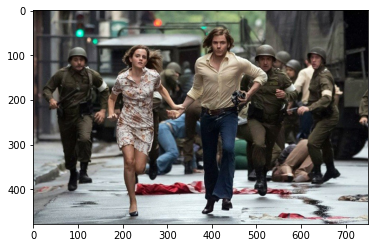

In [44]:
showresult('./testImages/test_images/randomimage0.jpg')

<start> a football player in a red uniform is tackling another player . <end>


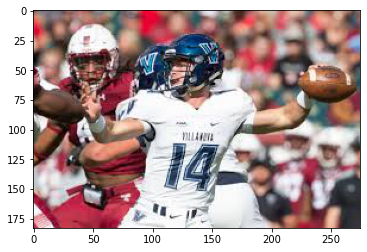

In [45]:
showresult('./testImages/test_images/randomimage7.jpg')

<start> a man in a black shirt is doing a back flip . <end>


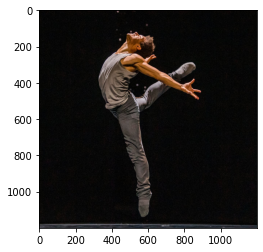

In [46]:
showresult('./testImages/test_images/randomimage8.jpg')

<start> a soccer player in a red uniform is running with a ball . <end>


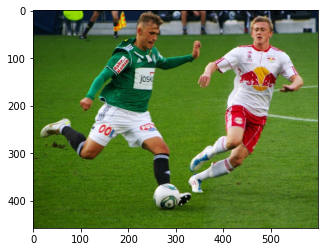

In [47]:
showresult('./testImages/test_images/randomimage4.jpg')

<start> a dog and a woman in jeans and a brown dog are standing in a dry field . <end>


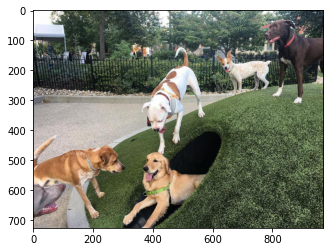

In [48]:
showresult('./testImages/test_images/randomimage5.jpg')

<start> a woman holds a baby in a baby wrap . <end>


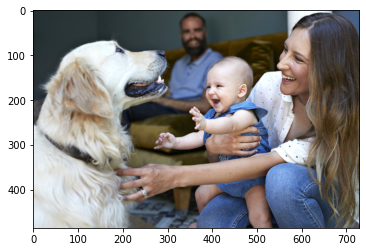

In [49]:
showresult('./testImages/test_images/randomimage6.jpg')

<start> a dog is jumping up to catch a tennis ball . <end>


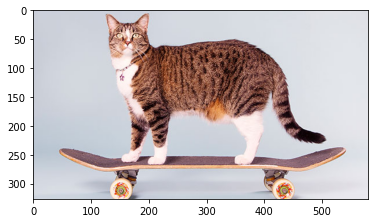

In [50]:
showresult('./testImages/test_images/randomimage9.jpg')

<start> a woman singing and playing music . <end>


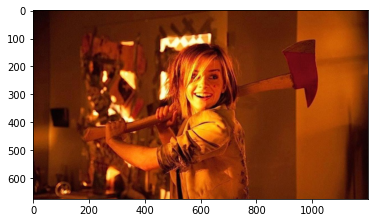

In [51]:
showresult('./testImages/test_images/randomimage3.jpg')

<start> a woman in a white coat is standing on a beach with a dog . <end>


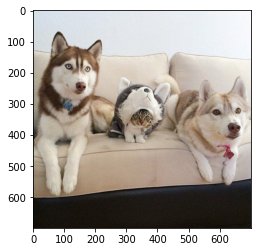

In [52]:
showresult('./testImages/test_images/randomimage1.jpg')

<start> a small girl in a yellow dress is sitting on a silver car . <end>


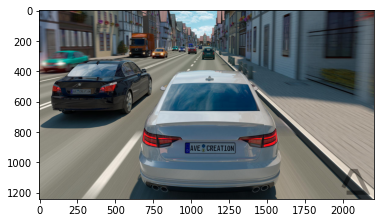

In [53]:
showresult('./testImages/test_images/randomimage2.jpg')